**Alunos:**
Marcela Cavalcante
Pedro Assis

**Imports**

In [ ]:
%pip install mlxtend --upgrade

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn import tree
from sklearn.tree import export_text, export_graphviz
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from mlxtend.evaluate import bias_variance_decomp
from sklearn.tree import DecisionTreeRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
drive.mount('/content/gdrive')
dados = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/temps.csv')
df = pd.DataFrame(dados)

Mounted at /content/gdrive


**Dicionário de Dados**

**year**: 2016. Ano em que os dados foram coletados.

**month**: Número do mês do ano.

**day**: Número do dia do ano.

**week**: dia da semana como uma string.

**temp_2**: Temperatura máxima 2 dias antes.

**temp_1**: Temperatura máxima 1 dia antes.

**average**: Temperatura máxima média historicamente.

**actual**: Temperatura máxima real.

**friend**: A previsão do seu amigo. Fica sempre um número aleatório de 1 a 20 abaixo ou acima da média.

**Contexto**

Esse dataset possui os dados climáticos de Seattle, WA de 2016. Será usado para treinar um modelo de machine learning à prever a temperatura máxima de um dia.

# **Parte 1**

**Exploração dos dados**

In [ ]:
df.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            348 non-null    int64  
 1   month           348 non-null    int64  
 2   day             348 non-null    int64  
 3   week            348 non-null    object 
 4   temp_2          348 non-null    int64  
 5   temp_1          348 non-null    int64  
 6   average         348 non-null    float64
 7   actual          348 non-null    int64  
 8   forecast_noaa   348 non-null    int64  
 9   forecast_acc    348 non-null    int64  
 10  forecast_under  348 non-null    int64  
 11  friend          348 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 32.8+ KB


In [ ]:
df.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


In [ ]:
df = df.drop(['year','forecast_noaa', 'forecast_acc', 'forecast_under'], axis=1)

**Preparação dos dados**

In [ ]:
#One Hot Encoding com pd.get_dummies()
df = pd.get_dummies(df)
df.head()

,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


<Axes: >

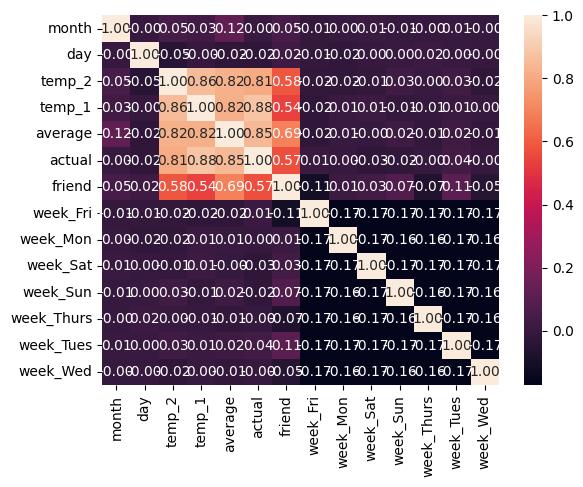

In [ ]:
sns.heatmap(df.corr(), annot=True, fmt=".2f")

**Sobre Normalização:** como estamos trabalhando com Árvores de Decisão não é necessário normalizar os dados, já que a Árvore trata cada coluna individualmente.

**Árvore de Decisão**

In [ ]:
train_size = int(0.8 * len(df))

# Split the data into training and testing sets
train_data = df[:train_size]
test_data = df[train_size:]

#Definindo X e y para treino
X_train = train_data.drop('actual', axis=1)
y_train = train_data['actual']

#Definindo X e y para teste
X_test = test_data.drop('actual', axis=1)
y_test = test_data['actual']

In [ ]:
#criando e treinando Árvore
model = tree.DecisionTreeRegressor(max_depth=550, criterion='squared_error', splitter='best') #adicionar parâmetros
model.fit(X_train, y_train)

#Predição e avaliação
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R^2 Score: ", r2)

R^2 Score:  0.6030295707856344


In [ ]:
#criando e treinando Árvore
model = tree.DecisionTreeRegressor(max_depth=550, criterion='absolute_error', splitter='best') #adicionar parâmetros
model.fit(X_train, y_train)

#Predição e avaliação
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R^2 Score: ", r2)

R^2 Score:  0.5344891815426747


**Cross Validation**

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
#criando e treinando Árvore
depths = [100, 300, 550, 750, 900, 1000]
for d in depths:
  model = tree.DecisionTreeRegressor(max_depth=d, criterion='squared_error',splitter='best')

  #Calculando array de r2_scores
  r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=tscv)

  # Calculate the average R^2 score
  avg_r2 = np.mean(r2_scores)

  print("\n")
  print("R^2 Scores: ", r2_scores)
  print("Avarage R^2 " , avg_r2)



R^2 Scores:  [-0.99014975 -0.58325992 -0.85330054 -2.16238789 -0.19838143]
Avarage R^2  -0.9574959039400331


R^2 Scores:  [-0.8577563  -0.47050468 -1.34652879 -2.18929546 -0.1474903 ]
Avarage R^2  -1.0023151070448402


R^2 Scores:  [-1.2634325  -0.61441234 -1.03110286 -1.70869622 -0.23044981]
Avarage R^2  -0.9696187446949388


R^2 Scores:  [-1.2634325  -0.62185584 -1.35853622 -2.57571819 -0.14261033]
Avarage R^2  -1.192430615312696


R^2 Scores:  [-1.40786173 -0.75032513 -1.41072235 -2.42473677  0.04422284]
Avarage R^2  -1.1898846281933642


R^2 Scores:  [-1.50414788 -0.65328395 -1.36315446 -2.43594826 -0.04361663]
Avarage R^2  -1.2000302371298035


**Modelo Final**

In [ ]:

model = tree.DecisionTreeRegressor(max_depth=550, criterion='squared_error',splitter='best')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R^2 Score: ", r2)

R^2 Score:  0.5547517644808247


**Bias & Variance**

In [ ]:
def get_bias_var(tree, X_train, y_train, X_test, y_test, loss_type):
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(tree, X_train, y_train, X_test, y_test, loss=loss_type, random_seed=123)

    print('Average expected loss: %.3f' % avg_expected_loss)
    print('Average bias: %.3f' % avg_bias)
    print('Average variance: %.3f' % avg_var)
    return

# Convertendo os DataFrames para arrays
X_train_arr = X_train.values
y_train_arr = y_train.values
X_test_arr = X_test.values
y_test_arr = y_test.values

tree_reg = DecisionTreeRegressor(random_state=123)
error_dt, bias_dt, var_dt = bias_variance_decomp(tree_reg, X_train_arr, y_train_arr, X_test_arr, y_test_arr, 'mse', random_seed=123)

get_bias_var(tree_reg, X_train_arr, y_train_arr, X_test_arr, y_test_arr, 'mse')

Average expected loss: 45.803
Average bias: 25.639
Average variance: 20.164


In [ ]:
# Cria o modelo de árvore de decisão com poda
tree_pruned = tree.DecisionTreeRegressor(random_state=123, max_depth=2)

# Calcula o erro de viés, variância e total com a função bias_variance_decomp
error_dt_pruned, bias_dt_pruned, var_dt_pruned = bias_variance_decomp(tree_pruned, X_train_arr, y_train_arr, X_test_arr, y_test_arr, 'mse', random_seed=123)

# Calculando a variância total com um modelo de árvore de decisão não podado
tree_full = tree.DecisionTreeRegressor(random_state=123)
error_dt_full, bias_dt_full, var_dt = bias_variance_decomp(tree_full, X_train_arr, y_train_arr, X_test_arr, y_test_arr, 'mse', random_seed=123)

# Imprimindo as métricas de redução de variância e aumento de viés
print("variance Reduction:", str(np.round((var_dt_pruned/var_dt-1)*100,2)) + '%')
print("quando introduz viés:", str(np.round((bias_dt_pruned/bias_dt_full-1)*100, 2)) + '%')

variance Reduction: -52.0%
quando introduz viés: 131.57%


### **Visualização**

[Text(0.5669373187822165, 0.975, 'x[3] <= 66.5\nsquared_error = 114.872\nsamples = 278\nvalue = 65.32'),
 Text(0.3032780283505155, 0.925, 'x[4] <= 55.55\nsquared_error = 45.412\nsamples = 148\nvalue = 57.514'),
 Text(0.15488079896907217, 0.875, 'x[4] <= 49.25\nsquared_error = 23.698\nsamples = 85\nvalue = 53.176'),
 Text(0.05315721649484536, 0.825, 'x[4] <= 46.05\nsquared_error = 17.036\nsamples = 38\nvalue = 49.737'),
 Text(0.020618556701030927, 0.775, 'x[7] <= 0.5\nsquared_error = 3.76\nsamples = 5\nvalue = 42.8'),
 Text(0.015463917525773196, 0.725, 'x[9] <= 0.5\nsquared_error = 2.25\nsamples = 4\nvalue = 43.5'),
 Text(0.010309278350515464, 0.675, 'x[1] <= 1.5\nsquared_error = 0.222\nsamples = 3\nvalue = 44.333'),
 Text(0.005154639175257732, 0.625, 'squared_error = 0.0\nsamples = 1\nvalue = 45.0'),
 Text(0.015463917525773196, 0.625, 'squared_error = 0.0\nsamples = 2\nvalue = 44.0'),
 Text(0.020618556701030927, 0.675, 'squared_error = 0.0\nsamples = 1\nvalue = 41.0'),
 Text(0.02577319

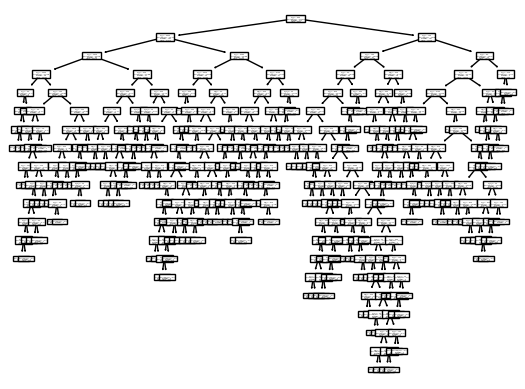

In [ ]:
tree.plot_tree(model)

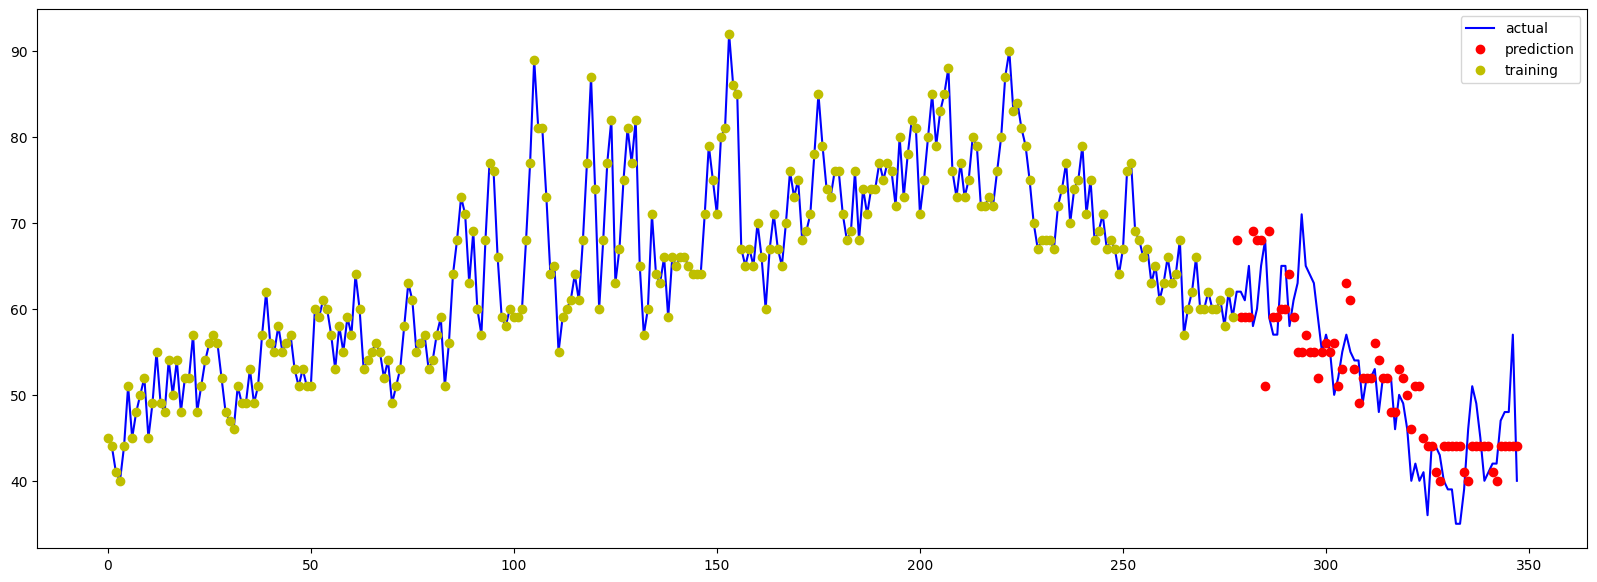

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(range(348), df['actual'], 'b-', label='actual')
plt.plot(y_test.index, y_pred, 'ro', label='prediction')
plt.plot(y_train.index, y_train, 'yo', label='training')
plt.legend()

# **Parte 2**

**Random Forests**

In [ ]:
#treinando o modelo
parameters = { 'n_estimators' : [100, 150, 200, 250, 300, 500, 550], 'criterion' : ['squared_error', 'absolute_error']}

forest_model = RandomForestRegressor(random_state = 42)
clf = GridSearchCV(forest_model, parameters)
clf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'n_estimators': [100, 150, 200, 250, 300, 500, 550]})

In [ ]:
# predição do modelo
y_pred = clf.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R^2: ", r2)

R^2:  0.6589688730927441


In [ ]:
'''#Predito VS Real
plt.plot(df['month'], df['actual'], 'b-', label='Actual')
plt.plot(df['month'], y_pred, 'ro', label='Prediction')
plt.legend()'''

"#Predito VS Real\nplt.plot(df['month'], df['actual'], 'b-', label='Actual')\nplt.plot(df['month'], y_pred, 'ro', label='Prediction')\nplt.legend()"

In [ ]:
#Exibindo resultados:
results = pd.DataFrame(zip(y_test, y_pred, y_test - y_pred), columns = ['y_test', 'y_pred', 'error'])
results.head(10)

,y_test,y_pred,error
0,62,62.046667,-0.046667
1,62,61.246667,0.753333
2,61,61.140000,-0.140000
3,65,60.680000,4.320000
4,58,61.640000,-3.640000
5,60,61.326667,-1.326667
6,65,61.166667,3.833333
7,68,58.606667,9.393333
8,59,73.606667,-14.606667
9,57,59.120000,-2.120000
